# Silhouette_v2

In [1]:
import torch
from torchvision.models import resnet18
from ignite.utils import manual_seed

from analyze import *

manual_seed(123)

## Prepare testee samples

sample batch


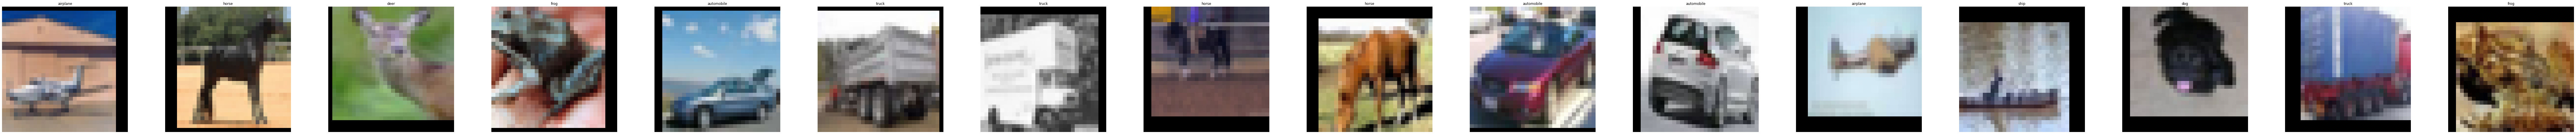

feature map before layer1: torch.Size([16, 64, 16, 16])
feature map between layer1 and layer2: torch.Size([16, 64, 8, 8])


In [2]:
%store -r sample_CIFAR10
sample = sample_CIFAR10

print(f'sample batch')
visualize_images(sample['batch']['images'],
                 sample['batch']['tags'],
                 sample['batch']['used_normalization'],
                 sample['batch']['classes'])

model = resnet18(pretrained=True)

def prepare_testee_samples(model, batch):
    testee_samples = {}
    
    def extract_feature_map(location):
        def hook(m, i, o):
            testee_samples[location] = o.detach()
        return hook
    
    handle1 = model.relu.register_forward_hook(extract_feature_map('before_layer1'))
    handle2 = model.layer1.register_forward_hook(extract_feature_map('between_layer1_and_layer2'))
    
    model(batch)
    
    handle1.remove()
    handle2.remove()
    
    return testee_samples
    
feature_maps = prepare_testee_samples(model, sample['batch']['images'])

print(f'feature map before layer1: {feature_maps["before_layer1"].size()}')
print(f'feature map between layer1 and layer2: {feature_maps["between_layer1_and_layer2"].size()}')

## Silhouette_v2_Conv2d

In [3]:
from architectures.Silhouette_v2.components_Silhouette_v2 import Silhouette_v2_Conv2d

def test_Silhouette_v2_Conv2d():
    print(f'**Silhouette_v2_Conv2d test**')
    
    threshold = 0.1
    in_channels = 64
    out_channels = 128
    
    print(f'simulate layer1.0.conv1: threshold: {threshold}')
    layer = Silhouette_v2_Conv2d(threshold, in_channels, out_channels)
    
    mask = layer(feature_maps['before_layer1'])
    print(mask.shape)
    print(mask)
    
    
test_Silhouette_v2_Conv2d()    

**Silhouette_v2_Conv2d test**
simulate layer1.0.conv1: threshold: 0.1


IndexError: too many indices for tensor of dimension 4

In [40]:
from architectures.Silhouette_v2.components_Silhouette_v2 import encode_policy

x = feature_maps['before_layer1']
print(f'x shape: {x.shape}')
threshold = 0.1
policy = '2bit 50%, 4bit 50%'
nbits, quantiles = encode_policy(policy)

mask = torch.mean(x, dim=[2, 3]).ge(threshold)
print(f'mask shape: {mask.shape}')


for i, (batch, m) in enumerate(zip(x, mask)):
    total = batch.shape[0]
    separation = int(total * quantiles[1])
    _, counts = torch.unique(m, return_counts=True)
    L, H = counts[0].item(), counts[1].item()
    
    print(f'total: {total}, separation: {separation}, L: {L}, H: {H}')
    
    if separation >= L:
        HL = H - separation
        HH = H - HH
        
    print(f'HH: {HH}, HL: {HL}')
    print(f'calculated total: {L + HL + HH}')

x shape: torch.Size([16, 64, 16, 16])
mask shape: torch.Size([16, 64])
total: 64, separation: 32, L: 18, H: 46
HH: 33, HL: 14
calculated total: 65
total: 64, separation: 32, L: 17, H: 47
HH: 14, HL: 15
calculated total: 46
total: 64, separation: 32, L: 18, H: 46
HH: 32, HL: 14
calculated total: 64
total: 64, separation: 32, L: 17, H: 47
HH: 15, HL: 15
calculated total: 47
total: 64, separation: 32, L: 17, H: 47
HH: 32, HL: 15
calculated total: 64
total: 64, separation: 32, L: 18, H: 46
HH: 14, HL: 14
calculated total: 46
total: 64, separation: 32, L: 16, H: 48
HH: 34, HL: 16
calculated total: 66
total: 64, separation: 32, L: 17, H: 47
HH: 13, HL: 15
calculated total: 45
total: 64, separation: 32, L: 17, H: 47
HH: 34, HL: 15
calculated total: 66
total: 64, separation: 32, L: 17, H: 47
HH: 13, HL: 15
calculated total: 45
total: 64, separation: 32, L: 16, H: 48
HH: 35, HL: 16
calculated total: 67
total: 64, separation: 32, L: 16, H: 48
HH: 13, HL: 16
calculated total: 45
total: 64, separa